In [1]:
import tensorflow as tf
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


c:\Users\thang\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [52]:
# from google.colab import drive
# drive.mount('/content/drive')

In [53]:
andrea = "./"
giaco = "/content/drive/MyDrive/DLA/"
path = andrea


In [20]:
def get_custom_test_sets():
    BlinksTest = [np.load('./test_sets/TestSetBlinksSlice1'),
                  np.load('./test_sets/TestSetBlinksSlice2'),
                  np.load('./test_sets/TestSetBlinksSlice3'),
                  np.load('./test_sets/TestSetBlinksSlice4'),
                  np.load('./test_sets/TestSetBlinksSlice5')]

    TestLabels = [np.load('./test_sets/TestSetLabelsSlice1'),
                  np.load('./test_sets/TestSetLabelsSlice2'),
                  np.load('./test_sets/TestSetLabelsSlice3'),
                  np.load('./test_sets/TestSetLabelsSlice4'),
                  np.load('./test_sets/TestSetLabelsSlice5')]
    return  BlinksTest, TestLabels


In [21]:
def custom_test(file, labels):
    Blinks = np.load(file)
    Labels = np.load(labels)
    Blinks[:,:,0]=(Blinks[:,:,0]-np.mean(Blinks[:,:,0]))/np.std(Blinks[:,:,0])
    Blinks[:,:,1]=(Blinks[:,:,1]-np.mean(Blinks[:,:,1]))/np.std(Blinks[:,:,1])
    Blinks[:,:,2]=(Blinks[:,:,2]-np.mean(Blinks[:,:,2]))/np.std(Blinks[:,:,2])
    Blinks[:,:,3]=(Blinks[:,:,3]-np.mean(Blinks[:,:,3]))/np.std(Blinks[:,:,3])
    Labels[Labels==10] = 1 #abs(1-Labels)
    return Blinks, Labels

In [22]:
def create_Dataset_auto_split(testOnly=False):
    def unison_shuffled_copies(a, b):
        p = np.random.permutation(len(a))
        return a[p], b[p]
    Blinks = np.load(os.path.join(path,'npy/Blinks_Full.npy'))
    Labels = np.load(os.path.join(path,'npy/Labels_Full.npy'))
    Blinks[:,:,0]=(Blinks[:,:,0]-np.mean(Blinks[:,:,0]))/np.std(Blinks[:,:,0])
    Blinks[:,:,1]=(Blinks[:,:,1]-np.mean(Blinks[:,:,1]))/np.std(Blinks[:,:,1])
    Blinks[:,:,2]=(Blinks[:,:,2]-np.mean(Blinks[:,:,2]))/np.std(Blinks[:,:,2])
    Blinks[:,:,3]=(Blinks[:,:,3]-np.mean(Blinks[:,:,3]))/np.std(Blinks[:,:,3])
    Labels[Labels==10] = 1
    step = (len(Blinks)//5)
    B, L, BT, LT = [],[],[],[]
    BlinksShuffled, LabelsShuffled = unison_shuffled_copies(Blinks, Labels)
    indexes = set(list(range(len(Blinks))))
    for i in range(5):
        if i < 4:
            LT.append(LabelsShuffled[i*step:(i+1)*step])
            BT.append(BlinksShuffled[i*step:(i+1)*step])
            B.append(BlinksShuffled[list(indexes.difference(list(range(i*step,(i+1)*step))))])
            L.append(LabelsShuffled[list(indexes.difference(list(range(i*step,(i+1)*step))))])
        else:
            LT.append(LabelsShuffled[i*step:])
            BT.append(BlinksShuffled[i*step:])
            B.append(BlinksShuffled[:i*step])
            L.append(LabelsShuffled[:i*step])

    return B,L, BT, LT


In [23]:
def create_model(model_name):
    if model_name == 'LSTMreza':
      input = tf.keras.Input(shape=(30, 4))
      x = tf.keras.layers.Dense(64, activation='relu')(input)
      x = tf.keras.layers.Masking(mask_value=0.0)(x)
      x = tf.keras.layers.LSTM(32,
                               recurrent_activation='sigmoid',
                               #batch_input_shape=(64, 30,64),
                               recurrent_dropout=0,
                               unroll=False,
                               use_bias=True,
                               return_sequences=False,
                               dropout=0.1)(x)
      x = tf.keras.layers.Dense(16, activation='relu')(x)
      x = tf.keras.layers.Dropout(0.2)(x)
      x = tf.keras.layers.Dense(16, activation='relu')(x)
      x = tf.keras.layers.Dense(8, activation='relu')(x)
      x = tf.keras.layers.Dropout(0.1)(x)
      y = tf.keras.layers.Dense(1, activation='tanh')(x)
      model = tf.keras.models.Model(inputs=[input], outputs=[y])

    elif model_name == 'giaco':
      input = tf.keras.Input(shape=(30, 4))
      x = tf.keras.layers.Dense(128, activation='relu')(input)
      x = tf.keras.layers.Masking(mask_value=0.0)(x)
      x = tf.keras.layers.LSTM(64, recurrent_activation='sigmoid',
                               recurrent_dropout=0,
                               unroll=False,
                               use_bias=True,
                               return_sequences=False,
                               dropout=0.1)(x)
      x = tf.keras.layers.Dense(128, activation='relu')(x)
      x = tf.keras.layers.Dropout(0.2)(x)
      x = tf.keras.layers.Dense(64, activation='relu')(x)
      x = tf.keras.layers.Dense(32, activation='relu')(x)
      x = tf.keras.layers.Dense(16, activation='relu')(x)
      x = tf.keras.layers.Dense(8, activation='relu')(x)
      y = tf.keras.layers.Dense(1, activation='tanh')(x)
      model = tf.keras.models.Model(inputs=[input], outputs=[y])
    elif model_name == 'giaco2':
      input = tf.keras.Input(shape=(30, 4))
      x = tf.keras.layers.Dense(64, activation='relu')(input)
      x = tf.keras.layers.Masking(mask_value=0.0)(x)
      x = tf.keras.layers.LSTM(32, recurrent_activation='sigmoid',
                               #batch_input_shape=(64, 30,64),
                               recurrent_dropout=0,
                               unroll=False,
                               use_bias=True,
                               return_sequences=False,
                               dropout=0.1)(x)
      x = tf.keras.layers.Dense(64, activation='relu')(x)
      x = tf.keras.layers.Dropout(0.1)(x)
      x = tf.keras.layers.Dense(32, activation='relu')(x)
      x = tf.keras.layers.Dropout(0.1)(x)
      x = tf.keras.layers.Dense(16, activation='relu')(x)
      x = tf.keras.layers.Dropout(0.1)(x)
      x = tf.keras.layers.Dense(8, activation='relu')(x)
      x = tf.keras.layers.Dropout(0.1)(x)
      y = tf.keras.layers.Dense(1, activation='sigmoid')(x)
      model = tf.keras.models.Model(inputs=[input], outputs=[y])
    else:
      print("Chiama le cose con il loro nome")
    return model

In [24]:
model_name = "giaco"
model = create_model(model_name)

## Ensembled


In [25]:
def create_models():
    models = []
    models.append(create_model('giaco'))
    models.append(create_model('LSTMreza'))
    models.append(create_model('giaco2'))
    return models


In [26]:
#dictionary of parameters for every net [ep, bs, lr]
def get_models_parameters():
    model1_parameters = {'name': 'giaco', 'ep': 100, 'bs': 128, 'lr': 0.00053}
    model2_parameters = {'name': 'LSTMreza','ep': 80, 'bs': 64, 'lr': 0.00053}
    model3_parameters = {'name': 'giaco2','ep': 200, 'bs': 64, 'lr': 0.000053}
    parameters = []
    parameters.append(model1_parameters)
    parameters.append(model2_parameters)
    parameters.append(model3_parameters)
    return parameters

In [27]:
def fit_models(models, parameters, ds, fold):
    Blinks, Labels, BlinksTest, LabelsTest = ds
    weight_for_0 = sum(Labels==1)/len(Labels.flatten())#num_pneumonia / (num_normal + num_pneumonia)
    weight_for_1 = sum(Labels==0)/len(Labels.flatten())#num_normal / (num_normal + num_pneumonia)
    class_weigths = {0: weight_for_0, 1: weight_for_1}
    for i in range(len(models)):
      name = parameters[i]['name']
      lr = parameters[i]['lr']
      bs = parameters[i]['bs']
      ep = parameters[i]['ep']
      filename = './models/BatchNormalized/' + fold + str(name) + 'ep=' + str(ep) + 'bs=' + str(bs) + 'lr=' + str(lr) +".keras"
      lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
            initial_learning_rate=lr,
            decay_steps=(len(Labels)//bs)*1000,
            decay_rate=1,
            staircase=False)
      models[i].compile(loss=tf.keras.losses.BinaryCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=['accuracy']
      )
      my_callbacks = [tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_loss', save_best_only=True)]
      print("Training: " + name)
      models[i].fit(x= Blinks, y = Labels, validation_data=(BlinksTest, LabelsTest), class_weight=class_weigths, epochs=ep, batch_size=bs, callbacks=my_callbacks)


In [7]:
#to check
def predict_all(models, test_set):
    labels = []
    for m in models:
        labels.append(m.predict(test_set).flatten())
    return  np.asarray(labels).transpose()

In [8]:
def ensemble(predictions):
    ensemble = predictions.mean(axis=1)
    ensemble[ensemble<0.5]=0
    ensemble[ensemble>=0.5]=1
    return ensemble


In [14]:
def compute_accuracy(true_labels, predicted_labels):
    acc = (sum(predicted_labels.flatten()==true_labels.flatten())/len(predicted_labels))*100
    print("Ensemble Accuracy: %2.4f" %acc + "%")
    return acc


In [65]:
Folds = ["Slice1","Slice2","Slice3","Slice4","Slice5"]

def train_5fold_models():
    datasets = create_Dataset_auto_split()
    for i, fold in enumerate(Folds):
        print("Training on " + fold)
        ds = datasets[0][i],datasets[1][i],datasets[2][i],datasets[3][i]
        models = create_models()
        parameters = get_models_parameters()
        fit_models(models, parameters, ds, fold)
        del models
        np.save(open("./test_sets/BatchNormalization/TestSetBlinks"+fold,'wb'),ds[2])
        np.save(open("./test_sets/BatchNormalization/TestSetLabels"+fold,'wb'),ds[3])

In [66]:
train_5fold_models()

Training on Slice1
Training: giaco
Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.5181 - loss: 0.6051 - val_accuracy: 0.6729 - val_loss: 0.6021
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6502 - loss: 0.2957 - val_accuracy: 0.6856 - val_loss: 0.5661
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6688 - loss: 0.2833 - val_accuracy: 0.6758 - val_loss: 0.5672
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6912 - loss: 0.2696 - val_accuracy: 0.6944 - val_loss: 0.5412
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6966 - loss: 0.2657 - val_accuracy: 0.7218 - val_loss: 0.5197
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7159 - loss: 0.2564 - val_accuracy: 0.7253 - val_loss: 0.5131
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7208 - loss: 0.2519 - val_accuracy: 0.7145 - val_loss: 0.5246
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.720

In [ ]:
import matplotlib.pyplot as plt

epochs = ['']
y = [94.8090, 90.9403, 94.0255, 91.7238, 93.2942]

# Vẽ đồ thị
plt.plot(animals, y, marker='o', linestyle='-', color='b')
plt.axhline(y=92.9585, color='r', linestyle='--')
plt.text(animals[1], 93, '92.9585', color='g')
for i in range(len(animals)):
    plt.text(animals[i], y[i], f'{y[i]:.2f}', ha='center', va='bottom', fontsize = 9)
plt.text(animals[i], y[i], f'{y[i]:.2f}', ha='center', va='bottom', fontsize = 9)

# Đặt tiêu đề và nhãn cho trục x, y
plt.title('The chart shows accuracy in tests')
plt.ylabel('Accuracy')

# Hiển thị đồ thị
plt.show()

In [100]:
def confusion_matrices(true, pred, slice):
    tn, fp, fn, tp = confusion_matrix(true, pred,labels=[0, 1]).ravel()
    array = [[tp, fp], [fn, tn]]
    df_cm = pd.DataFrame(array, index = ["Pred Alert", "Pred Sleepy"],
                      columns = ["True Alert", "True Sleepy"])
    plt.figure(figsize = (5,4))
    fig = sn.heatmap(df_cm, annot=True, fmt="d")
    fig.get_figure().savefig('../image/confMatSlice+'+str(slice) +'.png', dpi=400)

def five_fold_cross_validation(models_path):
    models = os.listdir(models_path)
    f1models, f2models, f3models, f4models, f5models = [],[],[],[],[]
    TB,TL = get_custom_test_sets()
    f1train,f2train,f3train,f4train,f5train = (TB[0],TL[0]),(TB[1],TL[1]),(TB[2],TL[2]),(TB[3],TL[3]),(TB[4],TL[4])
    for model in models:
        if "Slice1" in model:
            f1models.append(tf.keras.models.load_model(os.path.join(models_path,model)))
        if "Slice2" in model:
            f2models.append(tf.keras.models.load_model(os.path.join(models_path,model)))
        if "Slice3" in model:
            f3models.append(tf.keras.models.load_model(os.path.join(models_path,model)))
        if "Slice4" in model:
            f4models.append(tf.keras.models.load_model(os.path.join(models_path,model)))
        if "Slice5" in model:
            f5models.append(tf.keras.models.load_model(os.path.join(models_path,model)))
    splitted_models = [ f1models, f2models, f3models, f4models, f5models]
    test_sets = [f1train, f2train, f3train, f4train, f5train]
    accuracies = np.zeros(len(splitted_models))
    for index, test in enumerate(splitted_models):
        labels = predict_all(test, test_sets[index][0])
        ens = ensemble(labels)
        acc = compute_accuracy((test_sets[index][1]).flatten(), ens)
        confusion_matrices((test_sets[index][1]).flatten(), ens, index)
        accuracies[index] = acc
    print("Average accuracy is: %2.4f" %accuracies.mean(axis=0) + "%")

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Ensemble Accuracy: 94.8090%
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Ensemble Accuracy: 90.9403%
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Ensemble Accuracy: 94.0255%
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Ensemble Accuracy: 91.7238%
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Ensemble Accuracy: 93.2942%
Average accuracy is: 92.9585%


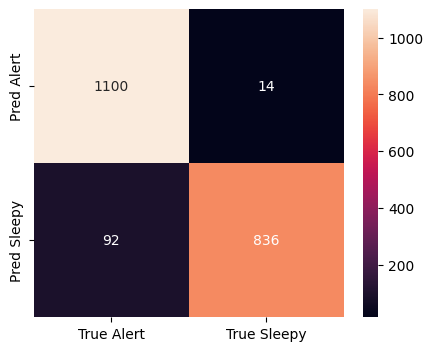

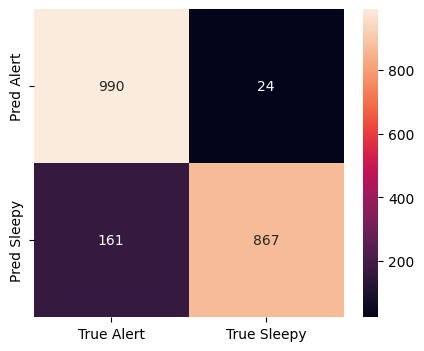

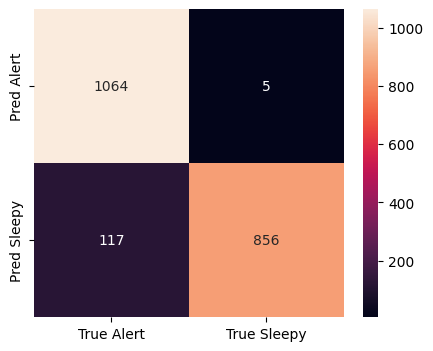

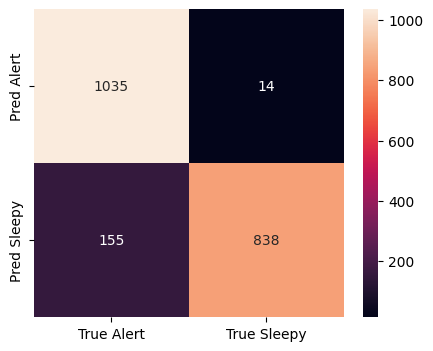

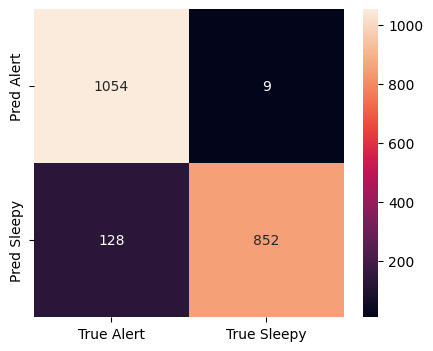

In [101]:
five_fold_cross_validation("./models/BatchNormalized/")

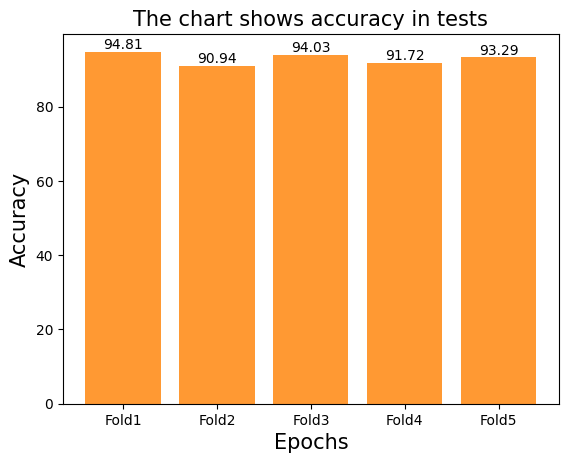

In [7]:
import matplotlib.pyplot as plt

animals = ['Fold1', 'Fold2', 'Fold3', 'Fold4', 'Fold5']
y = [94.8090, 90.9403, 94.0255, 91.7238, 93.2942]

# Vẽ đồ thị
plt.bar(animals, y, color='#FF9933')
for i in range(len(animals)):
    plt.text(animals[i], y[i], f'{y[i]:.2f}', ha='center', va='bottom', fontsize = 10)
# plt.text(animals[i], y[i], f'{y[i]:.2f}', ha='center', va='bottom', fontsize = 12)

plt.xlabel('Epochs', fontsize = 15)
# Đặt tiêu đề và nhãn cho trục x, y
plt.title('The chart shows accuracy in tests', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
# Hiển thị đồ thị
plt.show()

# PARTE SPERIMENTALE

In [8]:
models = []
models.append(tf.keras.models.load_model('./models/BatchNormalized/Slice1LSTMrezaep=80bs=64lr=0.00053.keras'))
models.append(tf.keras.models.load_model('./models/BatchNormalized/Slice1giaco2ep=200bs=64lr=5.3e-05.keras'))
models.append(tf.keras.models.load_model('./models/BatchNormalized/Slice1giacoep=100bs=128lr=0.00053.keras'))

In [9]:
Bt, Lt= np.load('./test_sets/BatchNormalization/TestSetBlinksSlice1'), np.load('./test_sets/BatchNormalization/TestSetLabelsSlice1')

NameError: name 'np' is not defined

In [12]:
Bt.shape

(2042, 30, 4)

In [15]:
# Bt, Lt = custom_test("./giacoBlinks","./giacoLabels")
ypred = predict_all(models, Bt)
ypred[ypred<=0.5]=0
ypred[ypred>0.5]=1
ens =  ensemble(ypred)
acc = compute_accuracy(Lt, ens)

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Ensemble Accuracy: 92.0176%


In [16]:
ypred

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       ...,
       [1., 1., 1.],
       [1., 0., 1.],
       [1., 1., 1.]], dtype=float32)

In [17]:
len(ens)

2042

In [33]:
len(ens)

2042

In [112]:
acc

92.01762977473066

In [113]:
for i, model in enumerate(models):
    print("Model %d" %i)
    model.summary()

Model 0


Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 30, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_89 (Dense)    │ (None, 30, 64)    │        320 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_14        │ (None, 30, 64)    │          0 │ dense_89[0][0]    │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_14          │ (None, 30, 64)    │          0 │ dense_89[0][0]    │
│ (Masking)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_118 (Any)       │ (None, 30)        │          0 │ not_equal_14[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ (None, 32)        │     12,416 │ masking_14[0][0], │
│                     │                   │            │ any_118[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_90 (Dense)    │ (None, 16)        │        528 │ lstm_14[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 16)        │          0 │ dense_90[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_91 (Dense)    │ (None, 16)        │        272 │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_92 (Dense)    │ (None, 8)         │        136 │ dense_91[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 8)         │          0 │ dense_92[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_93 (Dense)    │ (None, 1)         │          9 │ dropout_27[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 41,045 (160.34 KB)

 Trainable params: 13,681 (53.44 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 27,364 (106.89 KB)

Model 1


Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 30, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_94 (Dense)    │ (None, 30, 64)    │        320 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_15        │ (None, 30, 64)    │          0 │ dense_94[0][0]    │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_15          │ (None, 30, 64)    │          0 │ dense_94[0][0]    │
│ (Masking)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_120 (Any)       │ (None, 30)        │          0 │ not_equal_15[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ (None, 32)        │     12,416 │ masking_15[0][0], │
│                     │                   │            │ any_120[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_95 (Dense)    │ (None, 64)        │      2,112 │ lstm_15[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 64)        │          0 │ dense_95[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_96 (Dense)    │ (None, 32)        │      2,080 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 32)        │          0 │ dense_96[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_97 (Dense)    │ (None, 16)        │        528 │ dropout_29[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 16)        │          0 │ dense_97[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_98 (Dense)    │ (None, 8)         │        136 │ dropout_30[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 8)         │          0 │ dense_98[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_99 (Dense)    │ (None, 1)         │          9 │ dropout_31[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,805 (206.27 KB)

 Trainable params: 17,601 (68.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 35,204 (137.52 KB)

Model 2


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 30, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_82 (Dense)    │ (None, 30, 128)   │        640 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_13        │ (None, 30, 128)   │          0 │ dense_82[0][0]    │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_13          │ (None, 30, 128)   │          0 │ dense_82[0][0]    │
│ (Masking)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_122 (Any)       │ (None, 30)        │          0 │ not_equal_13[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 64)        │     49,408 │ masking_13[0][0], │
│                     │                   │            │ any_122[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_83 (Dense)    │ (None, 128)       │      8,320 │ lstm_13[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 128)       │          0 │ dense_83[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_84 (Dense)    │ (None, 64)        │      8,256 │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_85 (Dense)    │ (None, 32)        │      2,080 │ dense_84[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_86 (Dense)    │ (None, 16)        │        528 │ dense_85[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_87 (Dense)    │ (None, 8)         │        136 │ dense_86[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_88 (Dense)    │ (None, 1)         │          9 │ dense_87[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 208,133 (813.02 KB)

 Trainable params: 69,377 (271.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 138,756 (542.02 KB)

In [114]:
# ens =  ensemble(labels)

In [115]:
# acc = compute_accuracy(LabelsTest, ens)

In [116]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000053),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [117]:
# model.fit(x=B, y=L, validation_data=(Bt,Lt), epochs=80, batch_size=64)

In [6]:
model = tf.keras.models.load_model('./models/BatchNormalized/Slice1giaco2ep=200bs=64lr=5.3e-05.keras')
#model.evaluate(x=BlinksTest3, y=LabelsTest3.flatten())

In [7]:
model.evaluate(x=Bt, y=Lt)

NameError: name 'Bt' is not defined

In [18]:
ypred = predict_all([model], Bt)
ypred[ypred<0.5]=0
ypred[ypred>=0.5]=1
ypred

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [0.],
       [1.]], dtype=float32)

In [23]:
y_pred = ypred.flatten()
count = 0
for i in y_pred:
    if i == 0:
        count+=1
print(count)

1114


In [125]:
acc = compute_accuracy(Lt, ypred)

Ensemble Accuracy: 82.3702%


In [ ]:
# inp = B[:64,:,:]
# x = tf.keras.layers.Dense(64, activation='relu', dtype=tf.float64)(inp)

In [ ]:
# i = list(range(1553))
# v = [3,4,5]
# setA = set(i)
# setB = set(v)
# onlyInA = list(setA.difference(v))

In [4]:
import numpy as np
import os
x = np.load('./npy/BlinksTest_F1.npy', allow_pickle=True)
x.shape

(1816, 30, 4)

In [24]:
y = np.load('./test_sets/BatchNormalization/TestSetBlinksSlice1')
y

array([[[-0.20930554, -0.50057975, -0.15602831, -0.09014736],
        [-0.20930554, -0.30428631, -0.11249384, -0.48433281],
        [-0.20930554,  0.08975459, -0.09314518,  0.06752682],
        ...,
        [-0.20930554, -0.0527399 , -0.11249384, -0.66171627],
        [-0.20930554, -0.27811385, -0.05444787,  0.73764209],
        [-0.20930554, -0.43951068, -0.12216816, -0.81939045]],

       [[-0.16777538, -0.07568788, -0.37298064, -0.63680418],
        [-0.16777538, -0.40530223, -0.37298064, -0.11887612],
        [-0.16777538, -0.34349954, -0.48182966, -0.49555107],
        ...,
        [-0.16777538, -0.33834932, -0.37298064, -0.02470738],
        [-0.16777538,  0.15607221, -0.26413162,  0.14008791],
        [-0.16777538,  1.57238388,  1.04205664, -0.09533393]],

       [[-0.41869819, -0.49943042, -0.52162726, -0.5085702 ],
        [-0.41869819, -0.48349965, -0.45746992, -0.4955822 ],
        [-0.41869819, -0.38791502, -0.32915524, -0.54753419],
        ...,
        [-0.43217486,  0.36

In [28]:
ypred = predict_all([model], y)
ypred[ypred<0.5]=0
ypred[ypred>=0.5]=1
ypred = list(ypred.flatten()).count(0)
print(ypred)

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1114


In [5]:
# Load the saved model
import tensorflow as tf

model = tf.keras.models.load_model('models/BatchNormalized/Slice1LSTMrezaep=80bs=64lr=0.00053.keras')

# Access the training history
history = model.history

epochs = [i for i in range(1,201)]

# Extract the accuracy and loss values
accuracy_train = history.history['accuracy']
loss_train = history.history['loss']
accuracy_val = history.history['val_accuracy']
loss_val = history.history['val_loss']

plt.figure(figsize=(6,4))
# Vẽ đồ thị
plt.plot(epochs, accuracy_train, linestyle='-', color='b', label = "Accuracy Train")
plt.plot(epochs, accuracy_val, linestyle='-', color='orange', label = "Accuracy Validation")

# Đặt tiêu đề và nhãn cho trục x, y
plt.xlabel('Epochs', fontsize = 12)
plt.ylabel('Accuracy', fontsize = 12)
plt.title('Accuracy', fontsize = 15)
plt.legend(loc = 'upper right')
plt.show()


AttributeError: 'Functional' object has no attribute 'history'